# NLP Multi Class Example

- This notebook is based on the following tutorial
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f, however dataset size, class distribution and preparation steps are different

The problem is supervised text classification problem, and our goal is to first investigate the structure of the text and then look to use supervised learning methods (similar to logisitic regression and Decission Trees that we have seen already) in order to classify complaint descriptions to their assosiated products 


## 1. Import the Inspect the Data

In [30]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('rows.csv')
df.head(2)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228


The problem we are looking to solve is to predict theproduct from the customer complaint narritive. Therefore from this data we only need two columns 

1. Product
2. Consumer complaint narrative

In [31]:
df = df[['Product', 'Consumer complaint narrative']]

In [32]:
df.head(2)

,Product,Consumer complaint narrative
0,Checking or savings account,NaN
1,Checking or savings account,NaN


Lets look at how many samples we have 

In [5]:
len(df)

1282355

Almost 1.3 million samples in this case

We are only interested in trying to understand how to link the conusmer complaint narative to the product. So lets remove records that do not contain a consumer complaint 

In [34]:
df.isna().sum() # produces the number of null values in each column

Product                              0
Consumer complaint narrative    898791
dtype: int64

To remove the null values from the data we can use the code below. Notice how the length of the dataset is now signifcantly less

In [35]:
df = df[~df['Consumer complaint narrative'].isna()]
print(len(df))
df.head()

383564


,Product,Consumer complaint narrative
29904,"Credit reporting, credit repair services, or o...",The Summer of XX/XX/2018 I was denied a mortga...
30629,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
30735,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
30795,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
30807,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...


There looks to be dupicated data. Lets check for this and then remove that if we have it

In [8]:
df.duplicated().sum() #  total amount of dupilcated records

16441

As we did with null values we are going to remove the duplicate values from the dataset

In [36]:
df = df[~df.duplicated()]
df.head()

,Product,Consumer complaint narrative
29904,"Credit reporting, credit repair services, or o...",The Summer of XX/XX/2018 I was denied a mortga...
30629,"Credit reporting, credit repair services, or o...",There are many mistakes appear in my report wi...
31078,"Credit reporting, credit repair services, or o...",There is an account reporting on my credit rep...
31458,"Credit reporting, credit repair services, or o...",The reason for my writing is to inform you tha...
33083,"Credit reporting, credit repair services, or o...",XXXX and Transunion are reporting incorrectly ...


In [39]:
print(len(df)) #  length of the data we have left

367123


Our goal is to predict the product from the consumer complaint narrative. We therefore should have a look at the number of uniuqe products that we have

In [40]:
df.Product.nunique()

18

Lets look at the distribution of complaints per product to see if we have an unequal number of complaints per product. This is known as class imbalance and we would need to address this if it is the case.

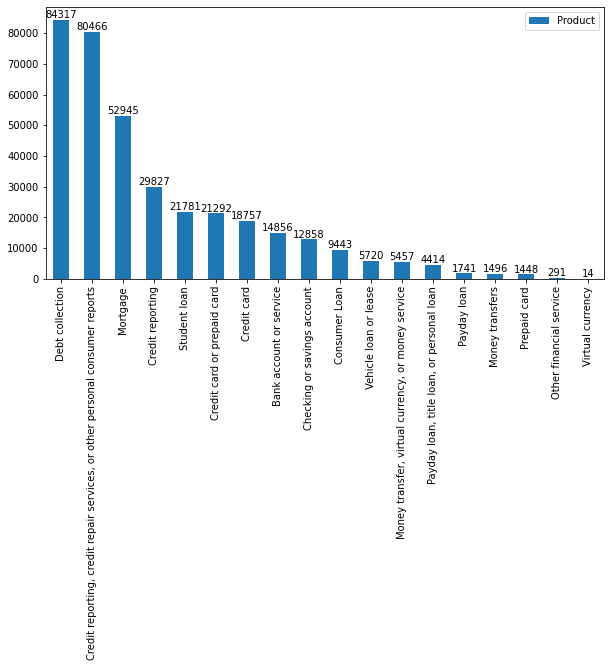

In [41]:
import matplotlib.pyplot as plt
ax = pd.DataFrame(df.Product.value_counts()).plot(kind = 'bar')
ax.bar_label(ax.containers[0])
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

The graph of the frequency per product clearly shows that the frequency of complaints for each product is different. Some supervised learning algorithms will bias decissions in favour of the categories that have a higher number of sample. This problem is known as class or category imbalance. 

There are a number of strategies we can use to deal with class imbalance. A good resource looking at this is here

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/


In summary you have the following options :
1) Collect more data for the minority classes
2) Some algoirthms will allow you to alter the performance metric you are optimising. Metrics such as accuracy are succeptable to class imbalance however f1 score would be more robust
3) Resample you dataset. This could inolve taking duplicates of the under sampled class in order to get the number of samples in each category even
4) Generate synthetic samples: In the minority class can you create synthetic data to increase the number of examples in that class
5) Add a penalty to your model : Some classification algroithms you can add a weight to different classes in the case where there is an incorrect prediction. 


In our case because we still have a number of categories with over 500 records we are going to downsample all classes with records greater than 500 in number and remove classes with less than this number from the problem. 

The code below is going to take only records whose products are greater than 500 and store the index of these records in a list that we shall use later

In [42]:
products = pd.DataFrame(df.Product.value_counts())[pd.DataFrame(df.Product.value_counts()).Product  > 500].index

For the records where there are greater than 500 products we are going to randomly sample each category such that 500 records are returned for each category

In [15]:
data = pd.DataFrame(columns = df.columns)
for product in products:
    sample = df[df.Product == product].sample(500)
    data = pd.concat([data, sample])
    


,Product,Consumer complaint narrative
725081,Payday loan,Big Picture loans. Fraudulent practices. Recei...
218023,Vehicle loan or lease,( The following is my written complaint to Hon...
860407,Credit card,"XXXX card no. XXXX, XXXX card no. XXXX and Cha..."
632714,Bank account or service,I refinanced my mortgage with XXXX XXXX XXXX t...
564438,Debt collection,Calling in excess of 12 times per day and refu...
142456,Vehicle loan or lease,"My car, a XXXX XXXX XXXX ( XXXX ) was paid off..."
844014,Credit card,I signed up for a card that advertised 0 % int...
571099,Bank account or service,Paypal has limited my account and is holding m...
399032,Vehicle loan or lease,Regarding my account with XXXX XXXX for a leas...
747168,Payday loan,Cashnet USA keeps debiting my Savings Account ...


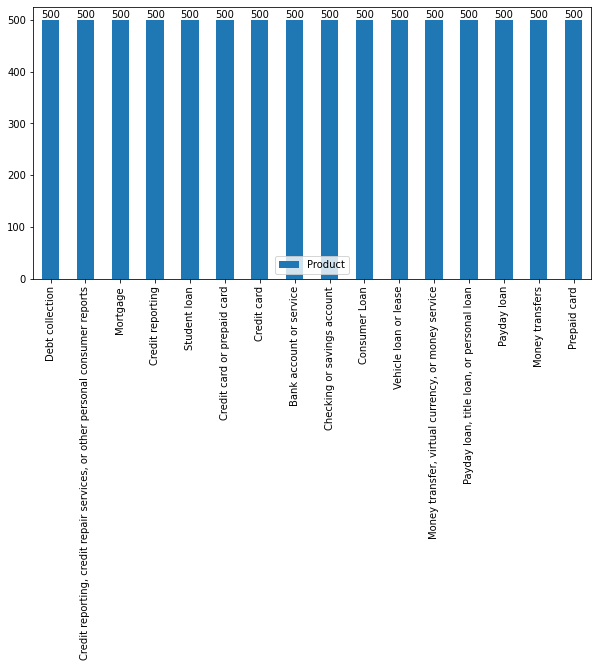

In [43]:
ax = pd.DataFrame(data.Product.value_counts()).plot(kind = 'bar')
ax.bar_label(ax.containers[0])
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

The evenly sampled data is now called data and not df

We want to make a column called category ID. This will be a numeric representation of the product. We can use the factoize method to do this. This returns a list where the first element is a list of ids that are assosiated with the product and the second element represents the list assosiated with the ids 

In [51]:
data['category_id'] = data['Product'].factorize()[0]
data.head(2)

,Product,Consumer complaint narrative,category_id
279147,Debt collection,Have no idea why this item shows on my credit ...,0
413229,Debt collection,I 've sent multiple letters to this agency abo...,0


We are now going to create a two dictionarys that allow us to map our category id to our product and our product to our category. We will be using this later

In [56]:
category_id_df = data[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)


In [57]:
print(id_to_category)
print(category_to_id)

{0: 'Debt collection', 1: 'Credit reporting, credit repair services, or other personal consumer reports', 2: 'Mortgage', 3: 'Credit reporting', 4: 'Student loan', 5: 'Credit card or prepaid card', 6: 'Credit card', 7: 'Bank account or service', 8: 'Checking or savings account', 9: 'Consumer Loan', 10: 'Vehicle loan or lease', 11: 'Money transfer, virtual currency, or money service', 12: 'Payday loan, title loan, or personal loan', 13: 'Payday loan', 14: 'Money transfers', 15: 'Prepaid card'}
{'Debt collection': 0, 'Credit reporting, credit repair services, or other personal consumer reports': 1, 'Mortgage': 2, 'Credit reporting': 3, 'Student loan': 4, 'Credit card or prepaid card': 5, 'Credit card': 6, 'Bank account or service': 7, 'Checking or savings account': 8, 'Consumer Loan': 9, 'Vehicle loan or lease': 10, 'Money transfer, virtual currency, or money service': 11, 'Payday loan, title loan, or personal loan': 12, 'Payday loan': 13, 'Money transfers': 14, 'Prepaid card': 15}


In [58]:
# col = ['Product', 'Consumer complaint narrative']
# df = df[col]
# df = df[pd.notnull(df['Consumer complaint narrative'])]
# df.columns = ['Product', 'Consumer_complaint_narrative']
# df['category_id'] = df['Product'].factorize()[0]
# category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
# category_to_id = dict(category_id_df.values)
# id_to_category = dict(category_id_df[['category_id', 'Product']].values)
# df.sample()

,Product,Consumer_complaint_narrative,category_id
610732,Consumer Loan,"We bought a new Toyota, XXXX XXXX and were pre...",9
516832,Money transfers,I was notified b y Paypal o n XXXX XXXX ...,14
84858,Checking or savings account,Today is XX/XX/XXXX. On XX/XX/XXXX I opened a ...,8
592276,Credit reporting,"A new po box was added to my report, & my addr...",3
547027,Credit reporting,"XXXX of XXXX, AR is improperly reporting a pai...",3
861797,Consumer Loan,I have received text messages that I never aut...,9
172921,"Payday loan, title loan, or personal loan",My Chase Credit Account was closed on XX/XX/XX...,12
889687,Credit reporting,I disputed the 'date of first delinquency ' wi...,3
710120,Prepaid card,I received a {$50.00} gift card from my employ...,15
585375,Credit reporting,I have provided documentation to all the XXXX ...,3


## 2. Exporatory Data Analysis

One of the easiest ways to perform EDA on text data is inspecting the word cloud for each cateory 

First lets look at a word cloud for consumer complaints for one product

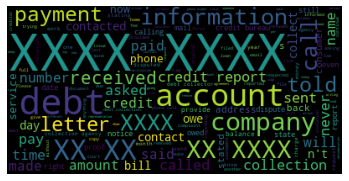

In [67]:
from wordcloud import WordCloud

# first combine all the complaints into one long text string
one_product = data[data.Product == products[0]]
text_string = "".join(complaint for complaint in one_product['Consumer complaint narrative'])
wordcloud = WordCloud().generate(text_string)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Lets now do this for each of our products

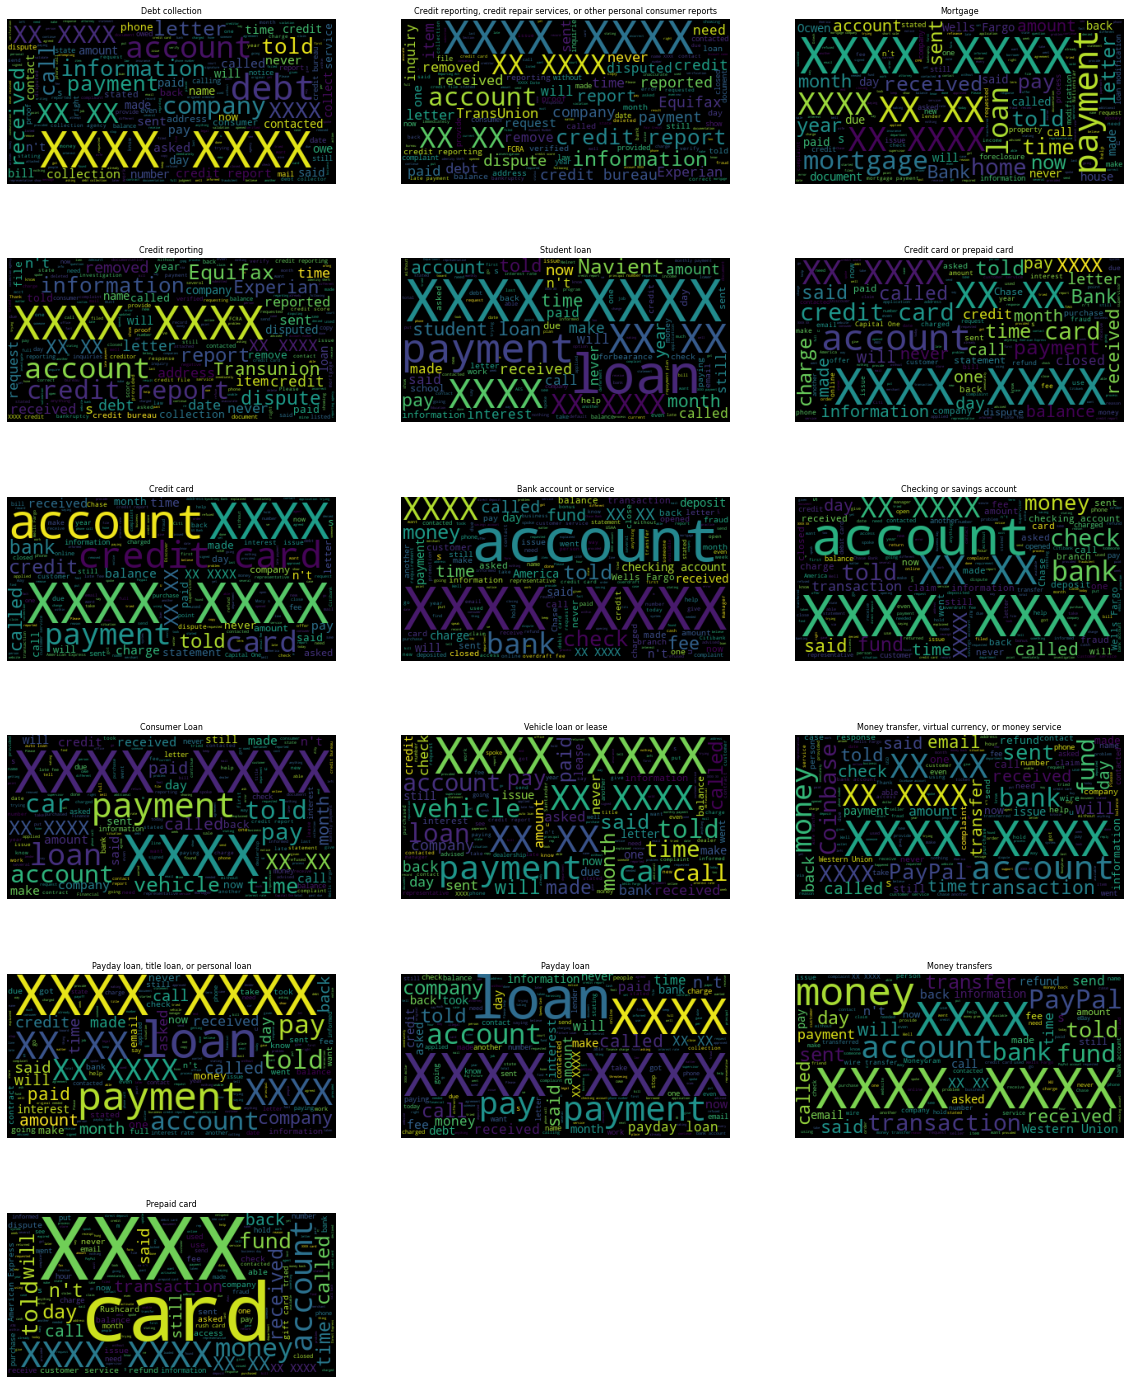

In [73]:
for i, product in enumerate(products):
    plt.subplot(7, 3, i +1)
    one_product = data[data.Product == product]
    text_string = "".join(complaint for complaint in one_product['Consumer complaint narrative'])
    wordcloud = WordCloud().generate(text_string)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(product, fontsize = 8)
    # plt.show()
fig = plt.gcf()
fig.set_size_inches(20, 30)

In the word cloud the size of the word indidcates the frequency in which it appears. We can look over these and words do seem to pop out that look like they would assosiate with a product

#### Encoding the data

Bag of Words is a commonly used algorithm in the field of Natural Language Processing (NLP) for feature extraction and text representation. The algorithm represents a document as a numerical vector, where each dimension in the vector corresponds to a unique word in a predefined vocabulary. The value in each dimension represents the frequency of occurrence of that word in the document.

The basic steps to implement the bag of words algorithm are:

Tokenization: The first step is to break down the document into individual words or tokens.

Vocabulary creation: The next step is to create a vocabulary of all the unique words in the corpus of documents. This can be done by constructing a dictionary where each key is a unique word and the value is its frequency of occurrence.

Encoding: Once the vocabulary is created, each document can be represented as a numerical vector, where each dimension in the vector corresponds to a word in the vocabulary. The value in each dimension represents the frequency of occurrence of that word in the document. This can be achieved by counting the number of occurrences of each word in the vocabulary for each document.

Normalization: To account for variations in document length, it is often useful to normalize the encoded vectors. This can be done by dividing each value by the total number of words in the document or by computing the term frequency-inverse document frequency (TF-IDF) value for each dimension.

The resulting bag of words representation can be used for various NLP tasks such as text classification, sentiment analysis, document similarity, etc. It provides a compact and efficient way to represent text data in a numerical format, which can be used as input to machine learning algorithms.



Below we will encode the data using tfidf approach.

The arguments used in the funciton are explained below here
- sublinear_df is set to True to use a logarithmic form for frequency.
- min_df is the minimum numbers of documents a word must be present in to be kept.
- norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
- ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams. ***
- stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.



*** *In the field of Natural Language Processing (NLP), unigrams and bigrams are terms used to describe sequences of words in a document. A unigram is a single word in a document. In the bag of words algorithm, each dimension in the numerical vector represents a unique unigram in the vocabulary. A bigram is a sequence of two words in a document that occur consecutively. In other words, a bigram represents the relationship between two neighboring words. Bigrams can provide additional information about the meaning and context of words in a document that is not captured by unigrams alone. In NLP, unigrams and bigrams are often used as features in text classification, sentiment analysis, and other tasks. By including both unigrams and bigrams in the feature representation, the algorithm can capture both the individual words and the relationships between words in the document. The use of bigrams can help improve the accuracy of the model in many cases.*

In [75]:
data.head(1)

,Product,Consumer complaint narrative,category_id
279147,Debt collection,Have no idea why this item shows on my credit ...,0


In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True,
                        min_df=5,
                        norm='l2', 
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(data['Consumer complaint narrative']).toarray()
labels = data.category_id
features.shape

(8000, 23729)

Now the data is 8000 records long however 23 thousands columns wide. This represents the vocabulary that is present in the dataset

Below we are going to use the chi2 statisitic to look at what features seem to corrolate with each product the most. 
For each product we get a metric for the influence of each of our 23000 columns on the product

In [91]:
from sklearn.feature_selection import chi2
import numpy as np

N =  2 # number of most correlated values we wish to observe
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id) # get the raw chi2 for each column
    indices = np.argsort(features_chi2[0]) # sort by the highest chi2
    feature_names = np.array(tfidf.get_feature_names())[indices] # get the feature name that relates to the chi2 value
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1] #  list of all the unigrams in the text
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2] # list of all the bigrams in the text
    print("# ", Product)
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) 

#  Bank account or service
  . Most correlated unigrams:
       . scottrade
       . overdraft
  . Most correlated bigrams:
       . overdraft fees
       . bank america
#  Checking or savings account
  . Most correlated unigrams:
       . savings
       . branch
  . Most correlated bigrams:
       . checking account
       . savings account
#  Consumer Loan
  . Most correlated unigrams:
       . vehicle
       . car
  . Most correlated bigrams:
       . chrysler capital
       . auto loan
#  Credit card
  . Most correlated unigrams:
       . card
       . macy
  . Most correlated bigrams:
       . discover card
       . credit card
#  Credit card or prepaid card
  . Most correlated unigrams:
       . citi
       . card
  . Most correlated bigrams:
       . annual fee
       . credit card
#  Credit reporting
  . Most correlated unigrams:
       . transunion
       . equifax
  . Most correlated bigrams:
       . trans union
       . credit report
#  Credit reporting, credit repair servi

## 3. Train the data - just another supervised classification problem

From this point on we can treat the code and the analsysi similar to how we would treat any other supervised classification problem. We have data with n rows m columns with n targets to predict. We should now split that data into train and test set so we can reliably evaluate how good our algorithm is working

In [159]:
from sklearn.model_selection import train_test_split

X = data['Consumer complaint narrative']
y = data['Product']
X_train, X_test, y_train, y_test = train_test_split(features, y , test_size = 0.2,  random_state = 42)

print('Number of training examples :' , len(X_train))
print('Number of testing examples :' , len(X_test))

Number of training examples : 6400
Number of testing examples : 1600


 In other problems we have used the decision tree algorithm from scikit learn. We could use that algorithm however commonly an alternative algorithm called Naive Bayes works well on text data. All scikit learn algorithms are coded in the same way. 

First we created an object , such as clf, which will be the name of the algorithm you want to use. Then you call the .fit function of this object and apply it to the training X and training y. 

In [152]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [163]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)


In [164]:
classification_report(y_true=y_train, y_pred=y_pred, target_names=clf.classes_)


'                                                                              precision    recall  f1-score   support\n\n                                                     Bank account or service       0.89      0.91      0.90       416\n                                                 Checking or savings account       0.87      0.97      0.91       406\n                                                               Consumer Loan       1.00      0.64      0.78       394\n                                                                 Credit card       0.92      0.88      0.90       401\n                                                 Credit card or prepaid card       0.93      0.87      0.90       398\n                                                            Credit reporting       0.91      0.85      0.88       391\nCredit reporting, credit repair services, or other personal consumer reports       0.70      0.87      0.78       405\n                                             

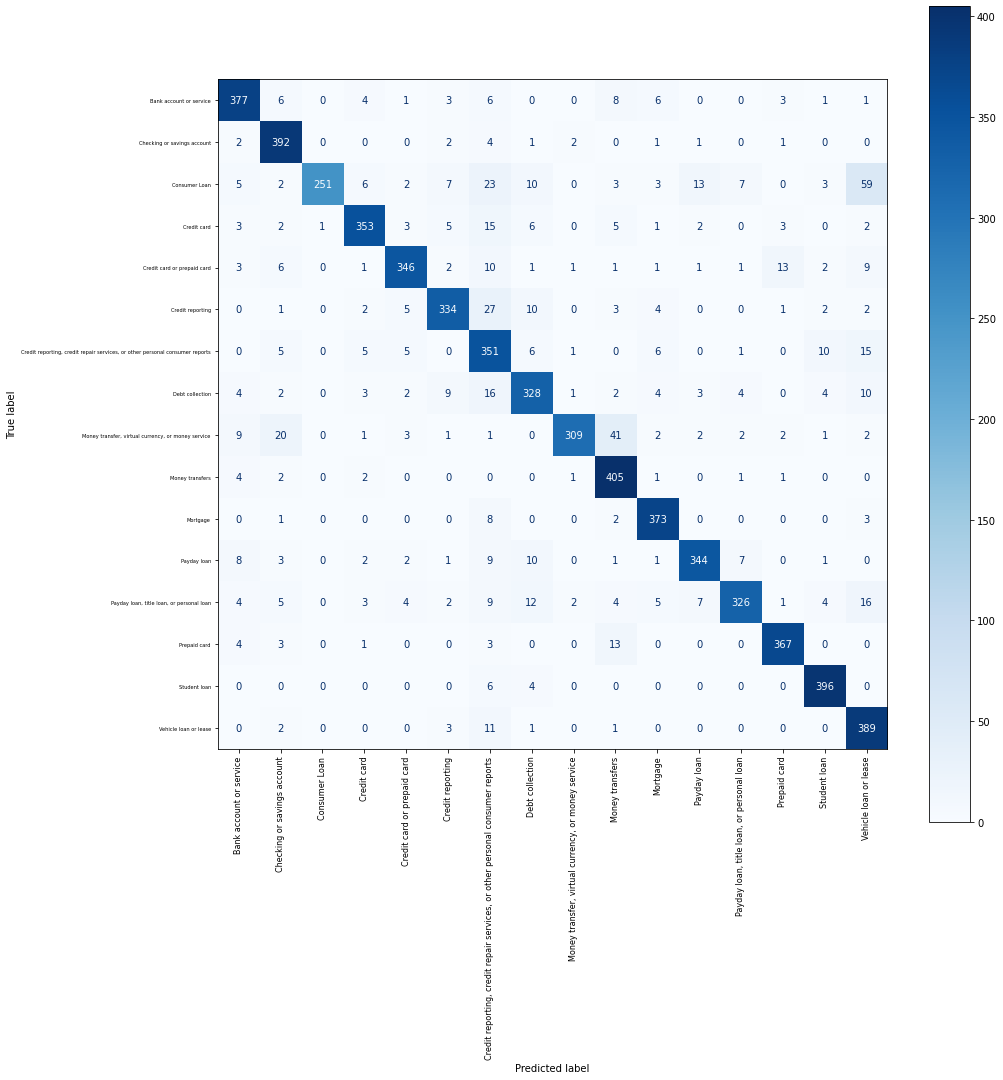

In [167]:
ConfusionMatrixDisplay.from_estimator(estimator=clf, X=X_train, y=y_train,cmap=plt.cm.Blues)
plt.grid(False);
ax = plt.gca()
ax.set_yticklabels(ax.get_yticklabels(), fontdict={'fontsize': 5})
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize': 8}, rotation = 90)
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()

### Check on test data

We should only do this once. We are going to see how this first model performs on the test data



In [168]:
y_pred = clf.predict(X_test)

In [169]:
classification_report(y_true=y_test, y_pred=y_pred, target_names=clf.classes_)

'                                                                              precision    recall  f1-score   support\n\n                                                     Bank account or service       0.51      0.48      0.49        84\n                                                 Checking or savings account       0.58      0.80      0.67        94\n                                                               Consumer Loan       0.90      0.08      0.16       106\n                                                                 Credit card       0.48      0.44      0.46        99\n                                                 Credit card or prepaid card       0.53      0.48      0.51       102\n                                                            Credit reporting       0.59      0.53      0.56       109\nCredit reporting, credit repair services, or other personal consumer reports       0.43      0.62      0.51        95\n                                             

See in the classification report the accuracy has now dropped to 0.6 from 0.88. This is telling us we want to change the type of algorithm we are using and the settings in order to see imporvements

### Select a different model

Other scikit learn algorthms that may do a better job at modelling this data are

- Logisitc regression
- Linear Support Vector Machine
- Random Forest

Below we are going to fit each of these models to the data and use cross validation to determine which model is likely to perform best . See the DT workshop notes for infomaiton on cross validation

In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [175]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)] # create a list of models


CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models))) # this is a "spreadsheet" that will store the cross validtion results
entries = []
for model in models:
    model_name = model.__class__.__name__ # get the model name
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV) # fit the model to  X_train
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy)) # get a list of the accuracies for each fold
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy']) # append this to the output df

We can now view the accuracies from each of our models in a table below

In [176]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.530469
1,RandomForestClassifier,1,0.472656
2,RandomForestClassifier,2,0.503906
3,RandomForestClassifier,3,0.500781
4,RandomForestClassifier,4,0.493750
5,LinearSVC,0,0.598437
6,LinearSVC,1,0.600000
7,LinearSVC,2,0.625781
8,LinearSVC,3,0.578906
9,LinearSVC,4,0.592969


We can visualise the results from each of the cross validation scores for each model in a box plot

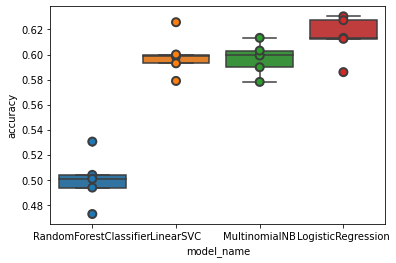

In [177]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=False, edgecolor="gray", linewidth=2)
plt.show()

To summarise the results from each model we can take the average accuracy for each model

In [178]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.599219
LogisticRegression        0.613906
MultinomialNB             0.596719
RandomForestClassifier    0.500312
Name: accuracy, dtype: float64

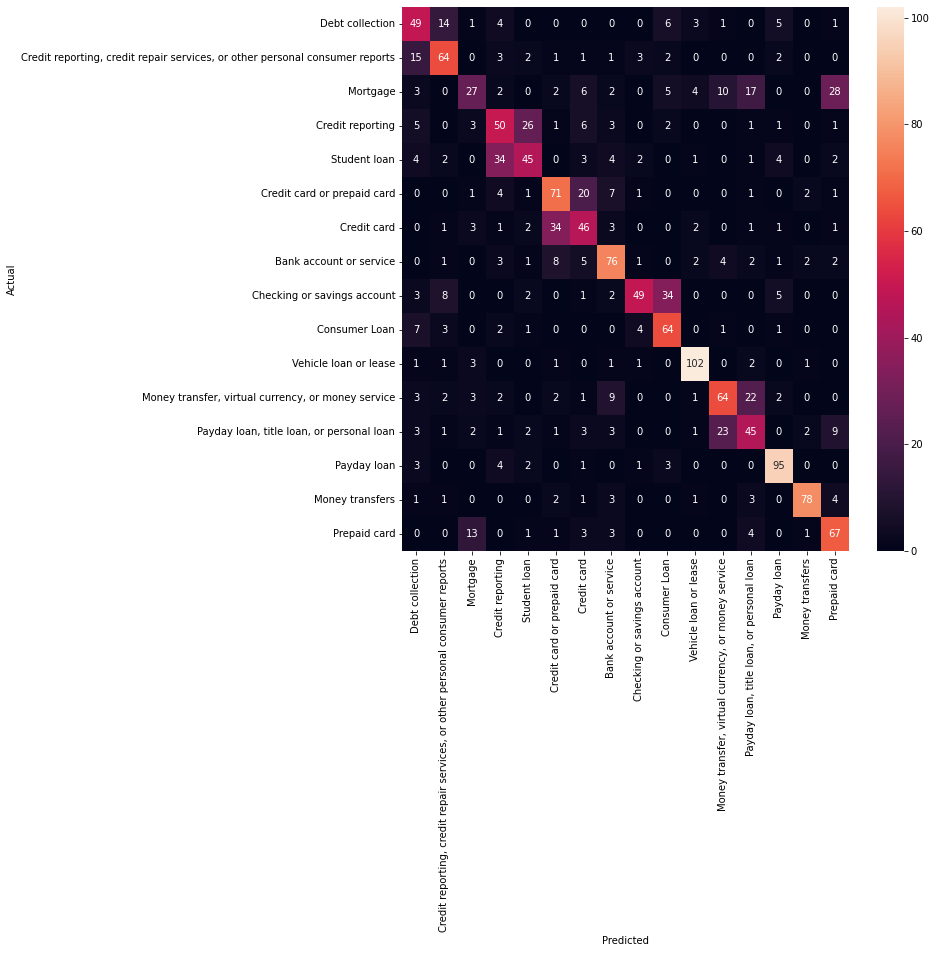

In [179]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [181]:
classification_report(y_true=y_test, y_pred=y_pred, target_names=model.classes_)

'                                                                              precision    recall  f1-score   support\n\n                                                     Bank account or service       0.51      0.58      0.54        84\n                                                 Checking or savings account       0.65      0.68      0.67        94\n                                                               Consumer Loan       0.48      0.25      0.33       106\n                                                                 Credit card       0.45      0.51      0.48        99\n                                                 Credit card or prepaid card       0.53      0.44      0.48       102\n                                                            Credit reporting       0.57      0.65      0.61       109\nCredit reporting, credit repair services, or other personal consumer reports       0.47      0.48      0.48        95\n                                             

## Conclusion and Next Steps

In the analysis above we have taken text statements and used these to predict the deparment that the text is refering too. We have tried multiple models and identified that we can achieve a predictive accuracy of just over 60% on testing data. When we look at the conufion matrix we can see that in some classes the accuracy of the prediction is far higher than 60% and in other categories we can see that the accuracy is worse. Given that we have 16 categories the baseline accuracy of random chance would be 16% so the model is a signficant imporvement on that. The model accuracy could be imporved by attempting other classification models, more extensive hyper param tuning or different encoding strategies. 

